### Stress Testing

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Clear any previous session and setup
tf.keras.backend.clear_session()

# Parameters
height, width = 224, 224
batch_size = 64

# Load the base VGG16 model without the fully connected layers
base_model = tf.keras.applications.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=(height, width, 3)
)
base_model.trainable = False

# Build the custom model
model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_vgg16.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

weights_path = 'C:/Users/ASUS/Desktop/vgg16_best.h5'  # Adjust this path as needed
model_vgg16.load_weights(weights_path)

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='sparse',  # 'binary' changed to 'sparse' for multi-class
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1, 'Covid': 2}
    )
    return generator


In [65]:
# Define the transformations for stress testing
def add_random_noise(image):
    noise_factor = 0.1
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = image + noise_factor * noise
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure the pixel values are valid
    return noisy_image

def add_blur(image):
    image = np.array(image * 255, dtype=np.uint8)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 4)
    blurred_image = blurred_image / 255.0  # Rescale back to [0, 1]
    return blurred_image

def apply_advanced_augmentations(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[height, width, 3])
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image.numpy()

In [66]:
# Stress testing function
def stress_test_model(model, data_generator):
    for batch in data_generator:
        images, labels = batch
        # Apply transformations
        noisy_images = np.array([add_random_noise(img) for img in images])
        blurred_images = np.array([add_blur(img) for img in images])
        augmented_images = np.array([apply_advanced_augmentations(img) for img in images])

        # Test model on original, noisy, blurred, and augmented images
        for test_images, description in zip([images, noisy_images, blurred_images, augmented_images], 
                                           ['Original', 'Noisy', 'Blurred', 'Augmented']):
            preds = model.predict(test_images)
            print(f"{description} images predictions:")
            # No decode_predictions since we have custom classes
            top_preds = np.argmax(preds, axis=1)
            print("Top class predictions:", top_preds)
        break  # Remove this to test on the entire dataset

In [68]:
# Directory paths
TESTING_DIR = 'C:/Users/ASUS/Desktop/Covid19-dataset/test'

# Generate data
test_generator = generate_data(TESTING_DIR)

# Define transformation functions (identity for original images)
def identity(image):
    return image

Found 66 images belonging to 3 classes.


In [69]:
def plot_confusion_matrices(model, data_generator):
    transformations = [
        (identity, 'Original'),
        (add_random_noise, 'Noisy'),
        (add_blur, 'Blurred'),
        (apply_advanced_augmentations, 'Augmented')
    ]

    plt.figure(figsize=(20, 5))  # Set figure size large enough to hold all subplots
    for i, (func, label) in enumerate(transformations, 1):
        true_labels = []
        pred_labels = []

        for batch in data_generator:
            images, labels = batch
            transformed_images = np.array([func(img) for img in images])
            preds = model.predict(transformed_images)
            pred_classes = np.argmax(preds, axis=1)

            true_labels.extend(labels)
            pred_labels.extend(pred_classes)
            
            # Limit to a single batch for demonstration; adjust as necessary
            break

        # Compute confusion matrix
        cm = confusion_matrix(true_labels, pred_labels)
        
        # Plotting
        ax = plt.subplot(1, 4, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix - {label}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
    
    plt.tight_layout()
    plt

1/1 [==============================] - 0s 279ms/step


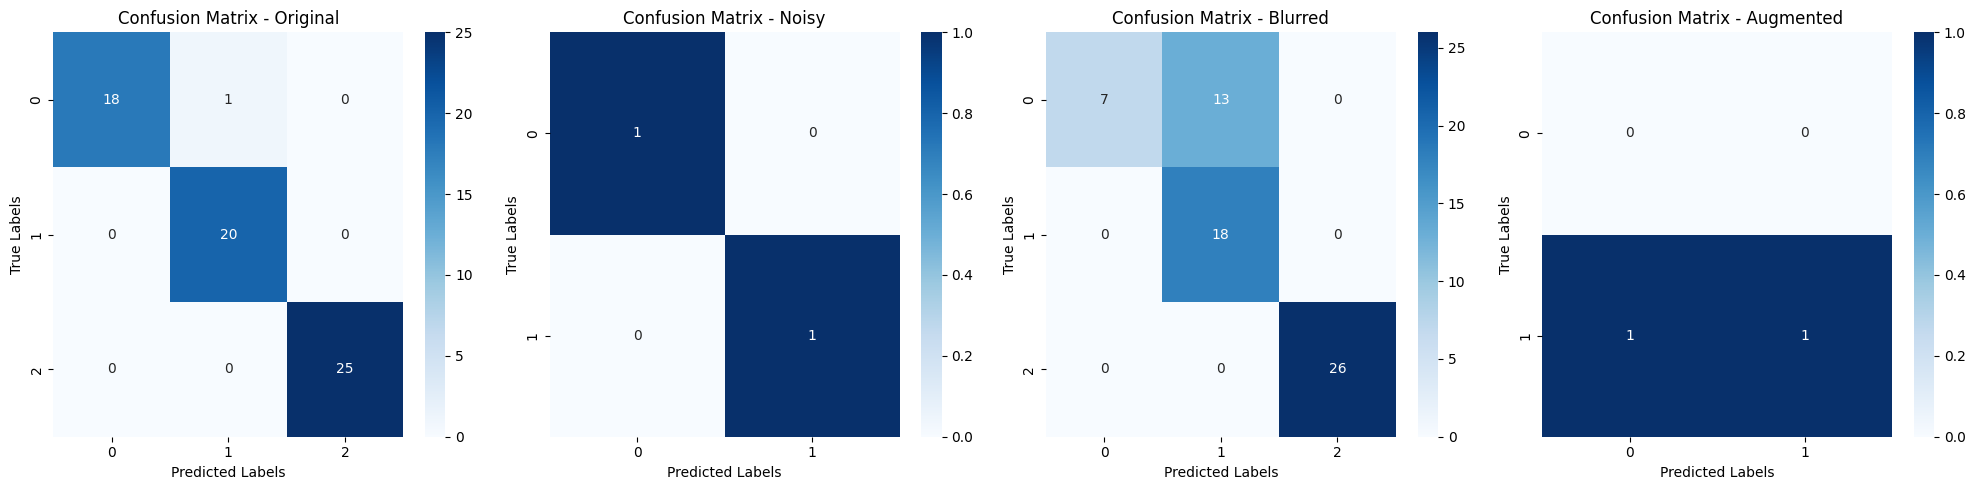

In [70]:
plot_confusion_matrices(model_vgg16, test_generator)

In [63]:
# Function to plot wrongly classified transformed images
from tensorflow.keras.applications.vgg16 import preprocess_input
def display_misclassified_transformed_images(model, data_generator, transform_func, description):
    plt.figure(figsize=(15, 5))
    count = 0
    class_names = list(data_generator.class_indices.keys())

    for batch in data_generator:
        images, labels = batch
        transformed_images = np.array([transform_func(img) for img in images])
        preds = model.predict(preprocess_input(transformed_images * 255))
        pred_classes = np.argmax(preds, axis=1)

        for i, (img, true, pred) in enumerate(zip(transformed_images, labels, pred_classes)):
            if true != pred:
                plt.subplot(1, 5, count + 1)
                plt.imshow(img)
                plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[int(true)]}', color='red')
                plt.axis('off')
                count += 1
                if count == 5:  # Display up to 5 misclassified images
                    break
        if count == 5:
            break

    plt.suptitle(f'Misclassified Transformed Images - {description}')
    plt.show()

Displaying misclassified transformed images...
2/2 [==============================] - 7s 4s/step


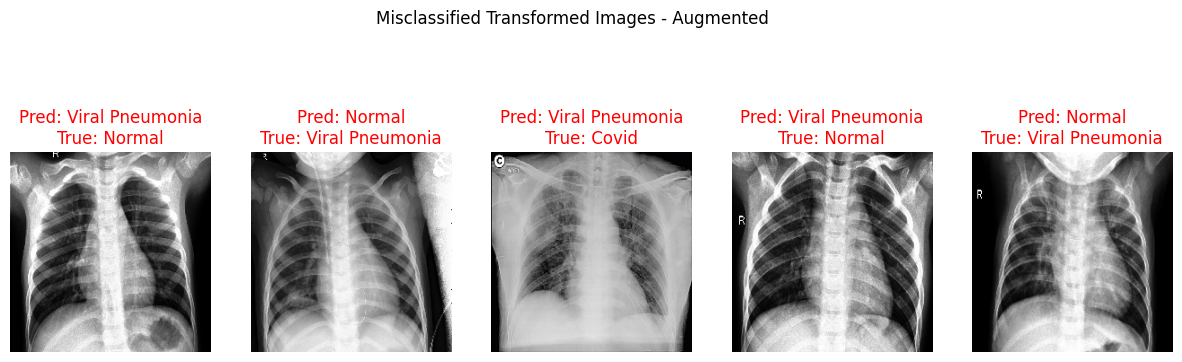

In [64]:
print("Displaying misclassified transformed images...")
display_misclassified_transformed_images(model_vgg16, test_generator, identity, 'Augmented')

In [ ]:


# Test and print confusion matrix for each case
print("Testing and generating confusion matrices...")
confusion_matrices = {}
confusion_matrices['Original'] = test_and_confusion_matrix(model_vgg16, test_generator, identity, 'Original')
confusion_matrices['Noisy'] = test_and_confusion_matrix(model_vgg16, test_generator, add_random_noise, 'Noisy')
confusion_matrices['Blurred'] = test_and_confusion_matrix(model_vgg16, test_generator, add_blur, 'Blurred')
confusion_matrices['Augmented'] = test_and_confusion_matrix(model_vgg16, test_generator, apply_advanced_augmentations, 'Augmented')

print("Confusion matrices generated for all cases.")

### Explainabilty

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.vgg16 import preprocess_input

# Prediction function adjusted for preprocessed batches
def predict(model, img_array):
    preds = model.predict(img_array)
    return preds

def explain_instance_with_lime(model, img_array, top_labels=5, hide_color=0, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        img_array.astype('double'),  # LIME expects double type images
        lambda x: predict(model, x),  # prediction function, img_array is already preprocessed
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples)

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False)

    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Explanation for class: ' + str(explanation.top_labels[0]))
    plt.axis('off')
    plt.show()

In [83]:
def explain_images(model, image_paths):
    for img_path in image_paths:
        # Load image
        img = image.load_img(img_path, target_size=(height, width))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess the image

        # Display the original image
        plt.imshow(image.img_to_array(img) / 255.0)
        plt.title("Original Image")
        plt.axis('off')
        plt.show()

        # Explain with LIME
        explain_instance_with_lime(model, img_array[0])

In [86]:
image_paths = [
    'C:/Users/ASUS/Desktop/Covid19-dataset/test/Covid/COVID-00022.jpg'
]

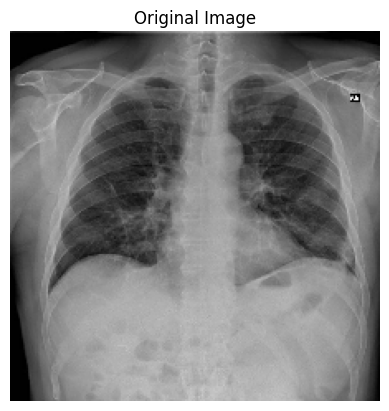

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


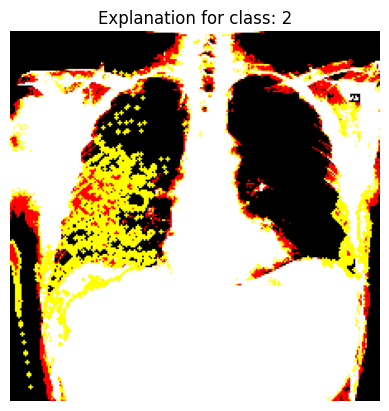

In [87]:
# Example usage
explain_images(model_vgg16, image_paths)

In [89]:
image_paths_2 = [
    'C:/Users/ASUS/Desktop/Covid19-dataset/test/Normal/0116.jpeg'
]

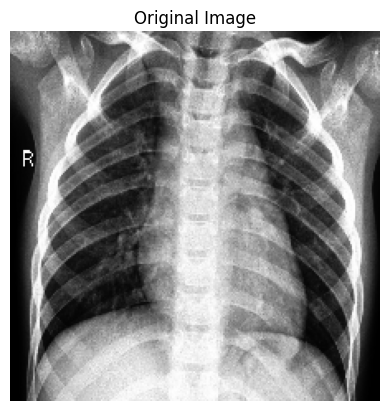

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


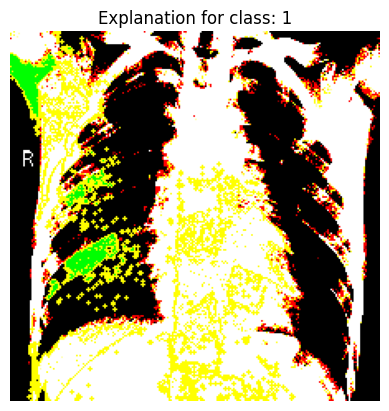

In [90]:
explain_images(model_vgg16, image_paths_2)

In [91]:
image_paths_3 = [
    'C:/Users/ASUS/Desktop/Covid19-dataset/test/Viral Pneumonia/0113.jpeg'
]
    

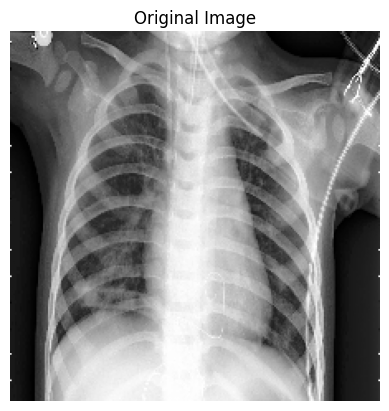

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


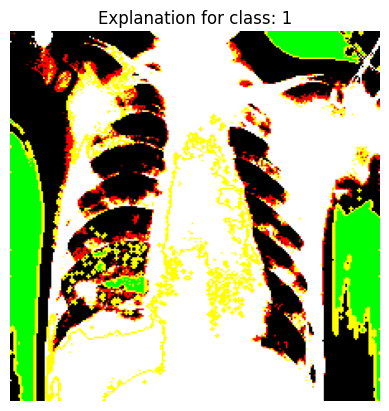

In [92]:
explain_images(model_vgg16, image_paths_3)

### Adverserial Examples

In [115]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter


def create_adversarial_pattern(input_image, input_label, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)
        
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

def generate_adversarial_examples(model, data_generator, epsilon=0.012):
    # Fetch a batch of images and labels from the data generator
    images, labels = next(data_generator)
    
    # List to store adversarial examples
    adversarial_examples = []
    
    for image, label in zip(images, labels):
        image = tf.expand_dims(image, axis=0)
        label = tf.expand_dims(label, axis=0)
        perturbations = create_adversarial_pattern(image, label, model)
        adversarial = image + epsilon * perturbations
        adversarial_examples.append(adversarial)
        
    return adversarial_examples, labels

In [116]:
def test_adversarial_examples(model, adversarial_examples, labels):
    correct = 0
    total = len(labels)
    
    for adv, label in zip(adversarial_examples, labels):
        pred = model.predict(adv)
        if np.argmax(pred) == label:
            correct += 1
    
    accuracy = correct / total
    print(f"Accuracy on adversarial examples: {accuracy * 100:.2f}%")

In [117]:
def display_adversarial_images(adversarial_examples):
    plt.figure(figsize=(10, 2.5))
    for i in range(4):
        index = np.random.randint(0, len(adversarial_examples))
        img = adversarial_examples[index].numpy().squeeze()
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [118]:
TESTING_DIR = 'C:/Users/ASUS/Desktop/Covid19-dataset/test'
# Generate data
test_generator = generate_data(TESTING_DIR)

# Clear any previous session and setup
tf.keras.backend.clear_session()

# Parameters
height, width = 224, 224
batch_size = 64

# Load the base VGG16 model without the fully connected layers
base_model = tf.keras.applications.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=(height, width, 3)
)
base_model.trainable = False

# Build the custom model
model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_vgg16.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

weights_path = 'C:/Users/ASUS/Desktop/vgg16_best.h5'  # Adjust this path as needed
model_vgg16.load_weights(weights_path)

Found 66 images belonging to 3 classes.


In [119]:
# Example of generating and testing adversarial examples
adversarial_examples, labels = generate_adversarial_examples(model_vgg16, test_generator)
test_adversarial_examples(model_vgg16, adversarial_examples, labels)

1/1 [==============================] - 0s 141ms/step
Accuracy on adversarial examples: 0.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


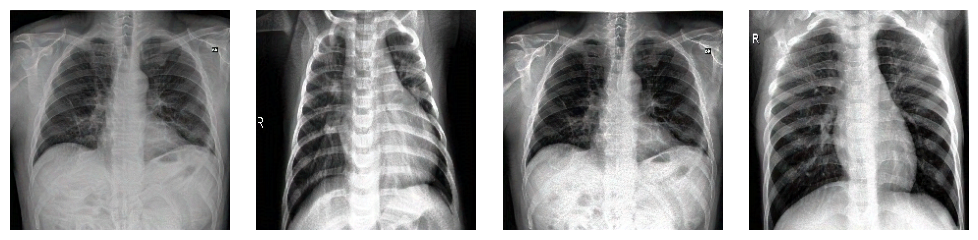

In [120]:
display_adversarial_images(adversarial_examples)